# 06. Decision Trees

**Author:** [Your Name/GitHub Username]
**Date:** June 2, 2025

## Introduction

Decision Trees are a non-parametric supervised learning method used for both **classification** and **regression** tasks. They work by learning simple decision rules inferred from the data features to predict the value of a target variable. The model is a tree-like structure where:
* Each **internal node** represents a "test" on an attribute (e.g., whether a feature is <= a value).
* Each **branch** represents the outcome of the test.
* Each **leaf node** (terminal node) holds a class label (for classification) or a continuous value (for regression).

One of the main advantages of decision trees is their high interpretability, as the learned rules can be easily visualized and understood.

* **Type:** Supervised Learning
* **Task:** Classification and Regression
* **Goal:** To create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features, represented as a tree structure.

## Theoretical Background

### 1. Tree Structure
* **Root Node:** The topmost node in the tree, representing the entire dataset.
* **Internal Node (Decision Node):** A node that splits into further sub-nodes based on a decision rule (a test on a feature).
* **Branch (Edge):** Connects nodes, representing the outcome of a test.
* **Leaf Node (Terminal Node):** A node that does not split further. It represents a class label (in classification) or a prediction value (in regression).

### 2. Building a Decision Tree (Recursive Partitioning)
The tree is built using a process called recursive partitioning:
1.  Start with all data at the root node.
2.  Find the "best" feature and the "best" split point for that feature that divides the data into subsets that are as "pure" as possible (i.e., ideally, each subset contains data points from a single class).
3.  Create a decision node based on this best split and create child nodes for each subset.
4.  Repeat this process recursively for each child node until a stopping criterion is met.

### 3. Splitting Criteria (How to choose the "best" split)
The quality of a split is typically measured by how much it reduces impurity or uncertainty in the child nodes compared to the parent node.

**For Classification Trees:**
* **Gini Impurity:** Measures the probability of misclassifying a randomly chosen element if it were randomly labeled according to the distribution of labels in the subset. For a node $N$ with $C$ classes:
    $Gini(N) = 1 - \sum_{i=1}^{C} (p_i)^2$
    where $p_i$ is the proportion of samples belonging to class $i$ in node $N$. A Gini impurity of 0 means all samples in the node belong to the same class (pure node).
    The Gini Gain for a split is: $GiniGain = Gini(parent) - \sum_{j} \frac{|N_{child,j}|}{|N_{parent}|} Gini(N_{child,j})$

* **Entropy & Information Gain:** Entropy measures the amount of uncertainty or randomness in a set of samples.
    $Entropy(N) = -\sum_{i=1}^{C} p_i \log_2(p_i)$
    Information Gain (IG) measures the reduction in entropy achieved by a split:
    $IG(N, \text{feature}) = Entropy(N) - \sum_{v \in \text{Values(feature)}} \frac{|N_v|}{|N|} Entropy(N_v)$
    The split with the highest information gain is chosen. Scikit-learn typically uses Gini impurity for its `DecisionTreeClassifier` by default (`criterion='gini'`).

**For Regression Trees:**
* The goal is to minimize the variance or error in the leaf nodes. Common criteria include:
    * **Mean Squared Error (MSE) Reduction (Variance Reduction):** The split is chosen that maximizes the reduction in MSE (or variance) between the parent node and the weighted average of the MSE (or variance) of the child nodes.
        $MSE(N) = \frac{1}{|N|} \sum_{i \in N} (y_i - \bar{y}_N)^2$, where $\bar{y}_N$ is the mean target value in node $N$.
        The prediction at a leaf node is usually the mean of the target values of the training instances in that leaf.

### 4. Stopping Criteria & Pruning
If a tree is grown too deep, it can overfit the training data. To prevent this:
* **Stopping Criteria (Pre-pruning):**
    * `max_depth`: Maximum depth of the tree.
    * `min_samples_split`: Minimum number of samples required to split an internal node.
    * `min_samples_leaf`: Minimum number of samples required to be at a leaf node.
    * `max_leaf_nodes`: Grow a tree with `max_leaf_nodes` in best-first fashion.
* **Pruning (Post-pruning):** Grow a full tree and then remove branches that provide little predictive power. Cost-complexity pruning (Minimal Cost-Complexity Pruning, `ccp_alpha` in scikit-learn) is a common method.

### 5. Feature Importance
Decision trees can estimate the importance of features. A common way is to measure the total reduction in the criterion (Gini impurity or MSE) brought by splits on that feature, averaged over all trees (if using an ensemble) or across the single tree. Features used higher up in the tree or more frequently are generally more important.

### Pros
* **Highly Interpretable:** Easy to understand and visualize the decision rules.
* Handles both numerical and categorical data (though scikit-learn's implementation requires numerical input; categorical data needs pre-processing like one-hot encoding).
* Requires little data preparation (e.g., no need for feature scaling if features are of different units).
* Non-parametric: Makes no assumptions about data distribution.
* Can capture non-linear relationships.
* Implicitly performs feature selection.

### Cons
* **Prone to Overfitting:** Can create overly complex trees that do not generalize well to unseen data. Pruning or setting stopping criteria is crucial.
* **Instability:** Small variations in the data can result in a completely different tree being generated. This is often mitigated by using ensembles like Random Forests.
* Can create biased trees if some classes dominate.
* Optimal decision tree learning is NP-complete. Greedy algorithms are used, which might not find the globally optimal tree.
* Decision boundaries are axis-parallel, which might not be ideal for all datasets.

### Common Use Cases
* Medical diagnosis (e.g., based on symptoms).
* Credit risk assessment.
* Customer segmentation.
* As a base learner in ensemble methods (Random Forests, Gradient Boosting).
* Any problem where interpretability of the model is important.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap # For decision boundary plotting

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler # Not strictly necessary for DTs
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree # Key imports
from sklearn import metrics # For accuracy, confusion matrix, classification report

# Set a style for seaborn plots
sns.set_style('whitegrid')

## Implementation with Python (Classification)

We'll use the **Iris dataset** from Scikit-learn for this classification example. We will use two features initially for decision boundary visualization, and then all features for a more complete model.

In [2]:
from sklearn.datasets import load_iris

# Load the dataset
iris = load_iris()

# --- Using all features for the main model ---
X_all_features = iris.data
y_all_features = iris.target

# --- For initial visualization, let's use only the first two features ---
X_viz = iris.data[:, :2] # Sepal length and sepal width
y_viz = iris.target

# Create Pandas DataFrames/Series (optional, for inspection)
X_df_all = pd.DataFrame(X_all_features, columns=iris.feature_names)
y_s_all = pd.Series(y_all_features, name='Target_Class')
target_names = iris.target_names

print("Features (X_df_all) - First 5 rows:")
print(X_df_all.head())
print(f"\nTarget names: {target_names}")

Features (X_df_all) - First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Target names: ['setosa' 'versicolor' 'virginica']


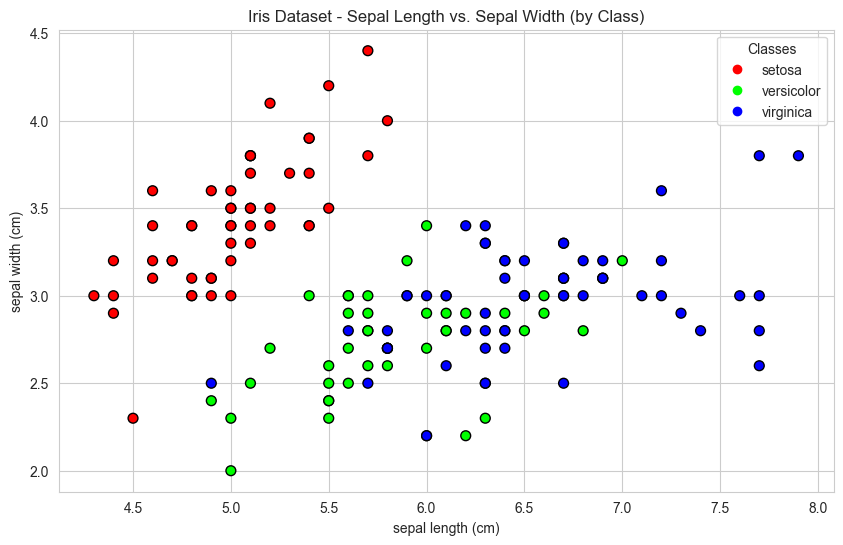

In [3]:
# Visualize the data using the two selected features (Sepal Length & Width)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_viz[:, 0], X_viz[:, 1], c=y_viz, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']), edgecolor='k', s=50)
plt.title('Iris Dataset - Sepal Length vs. Sepal Width (by Class)')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Classes")
plt.show()

In [4]:
# 1. Split the data (using all features)
X_train, X_test, y_train, y_test = train_test_split(X_df_all, y_s_all, test_size=0.3, random_state=42, stratify=y_s_all)

print(f"Training set size: X_train: {X_train.shape[0]}")
print(f"Testing set size: X_test: {X_test.shape[0]}")

# 2. Feature Scaling (Discussion Point)
# Decision Trees are not sensitive to feature scaling because they make decisions based on
# thresholds for individual features (e.g., feature_X > value_Y).
# The scale of the feature does not affect the split point selection process.
# So, scaling is generally NOT required for Decision Trees.
# We will proceed without scaling.

Training set size: X_train: 105
Testing set size: X_test: 45


In [5]:
# Create a Decision Tree classifier instance
# Some important hyperparameters:
# - criterion: 'gini' (default) or 'entropy'
# - max_depth: Maximum depth of the tree (to control overfitting)
# - min_samples_split: Minimum number of samples required to split an internal node
# - min_samples_leaf: Minimum number of samples required at a leaf node
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, random_state=42)
# Using max_depth=None initially to see a fully grown tree

# Fit the model
dt_classifier.fit(X_train, y_train)

print("Decision Tree Classifier trained.")

Decision Tree Classifier trained.


In [6]:
# Make predictions on the test set
y_pred_class = dt_classifier.predict(X_test)

# Display some predictions
predictions_df = pd.DataFrame({
    'Actual Target': y_test.values,
    'Predicted Class': y_pred_class
})
print("\nActual vs Predicted classes (first 10):")
print(predictions_df.head(10))


Actual vs Predicted classes (first 10):
   Actual Target  Predicted Class
0              2                2
1              1                1
2              2                2
3              1                2
4              2                2
5              2                2
6              1                1
7              1                1
8              0                0
9              2                2


### Model Evaluation Metrics (Classification)


Accuracy: 0.9333


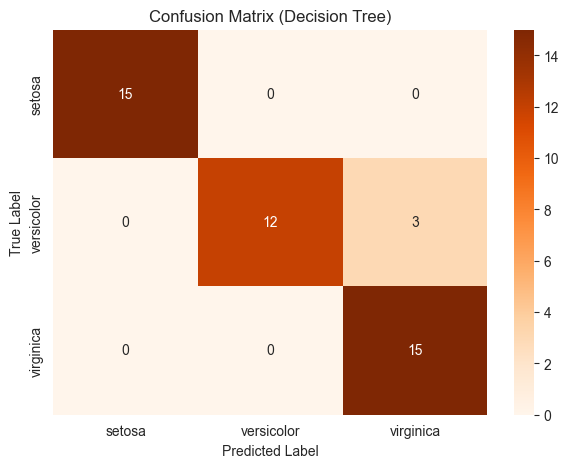


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.80      0.89        15
   virginica       0.83      1.00      0.91        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



In [7]:
# 1. Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(f"\nAccuracy: {accuracy:.4f}")

# 2. Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Decision Tree)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Classification Report
class_report = metrics.classification_report(y_test, y_pred_class, target_names=target_names)
print("\nClassification Report:")
print(class_report)

### Visualizing the Decision Tree
One of the key strengths of decision trees is their interpretability. We can visualize the trained tree.

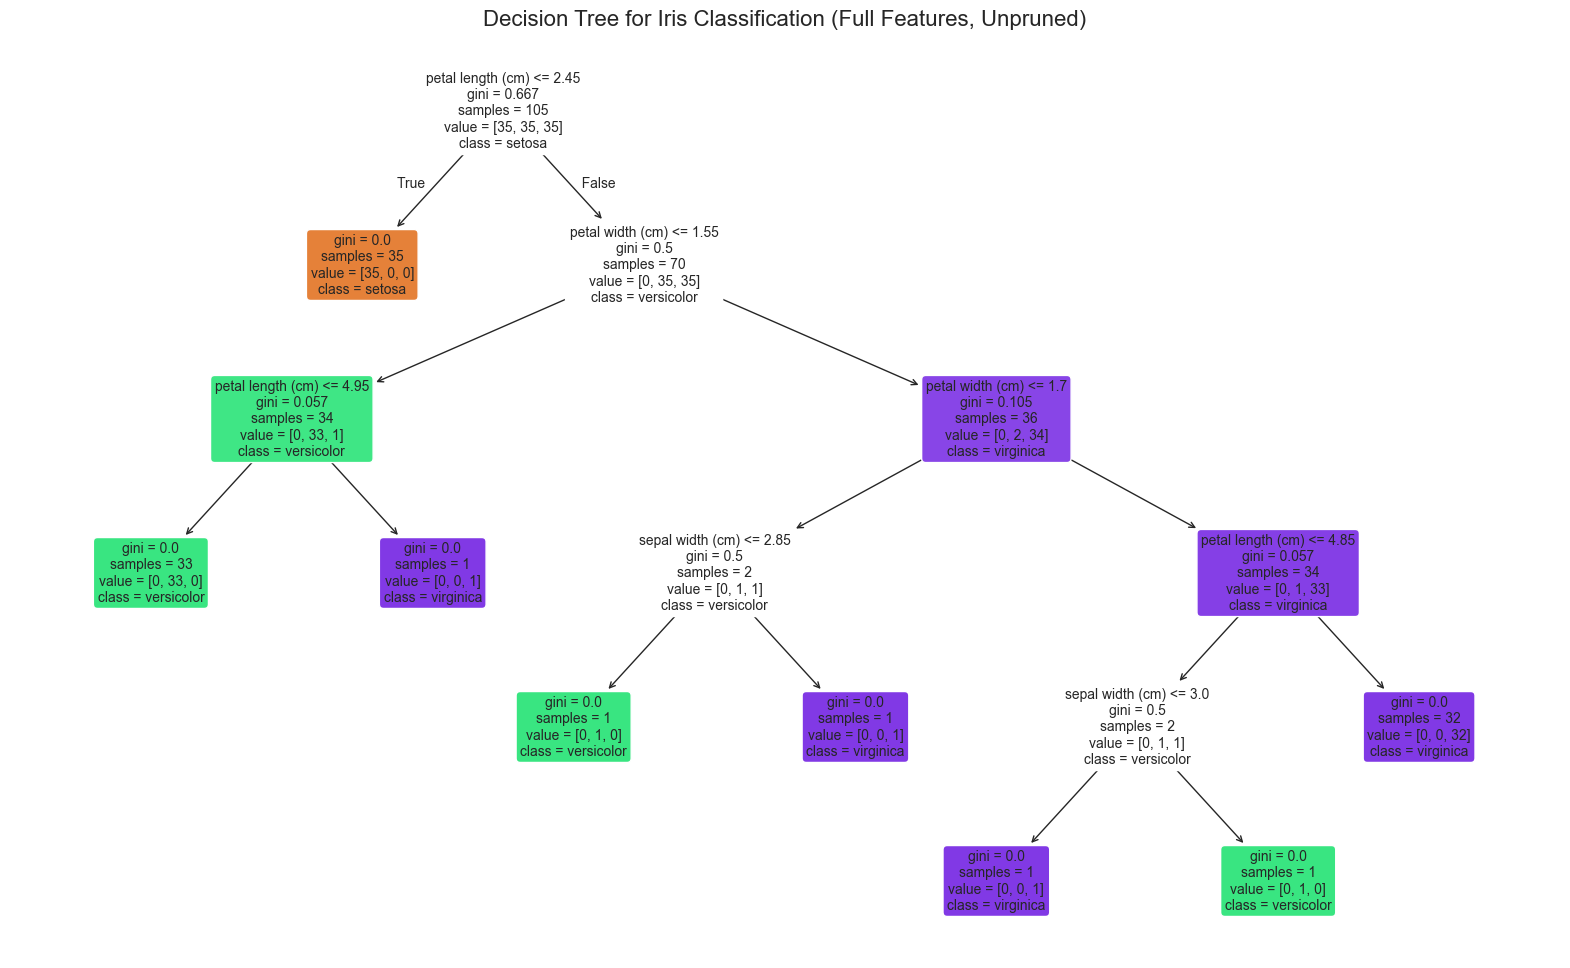

In [8]:
plt.figure(figsize=(20,12)) # Adjust figure size for better readability
plot_tree(dt_classifier,
          filled=True, # Fills nodes with colors based on majority class
          rounded=True, # Rounded corners for nodes
          class_names=target_names,
          feature_names=X_df_all.columns,
          fontsize=10)
plt.title("Decision Tree for Iris Classification (Full Features, Unpruned)", fontsize=16)
plt.show()

The visualized tree shows the decision rules at each node, the Gini impurity, the number of samples, and the class distribution. This makes it easy to understand how the model makes predictions. A very deep tree like this might be overfitting.

### Visualizing Decision Boundaries (for 2 features)
To visualize decision boundaries, we need to train a model using only two features.

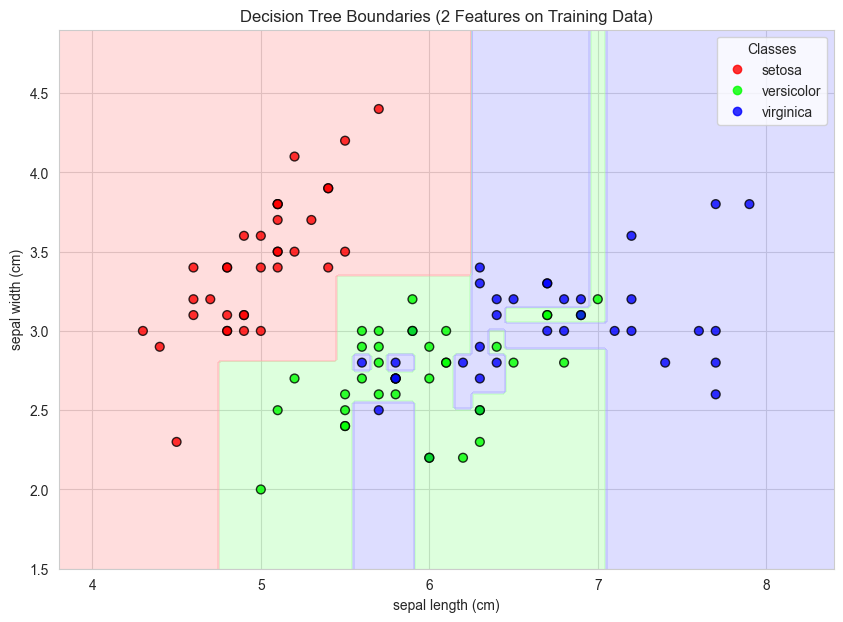

In [9]:
# Train a new DT model using only the first two features (X_viz, y_viz from earlier)
X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(X_viz, y_viz, test_size=0.3, random_state=42, stratify=y_viz)

# No scaling needed
dt_classifier_viz = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
dt_classifier_viz.fit(X_train_viz, y_train_viz)

def plot_decision_boundaries_dt(X_data, y_data, model, feature_names, target_names_list, title_suffix=""):
    X_np = X_data if isinstance(X_data, np.ndarray) else X_data.values
    y_np = y_data if isinstance(y_data, np.ndarray) else y_data.values

    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 7))
    custom_cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    custom_cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap_light)
    
    scatter_plot = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap=custom_cmap_bold, edgecolor='k', s=40, alpha=0.8)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'Decision Tree Boundaries {title_suffix}')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend(handles=scatter_plot.legend_elements()[0], labels=list(target_names_list), title="Classes")
    plt.show()

plot_decision_boundaries_dt(X_train_viz, y_train_viz, dt_classifier_viz, iris.feature_names[:2], target_names, "(2 Features on Training Data)")

The decision boundaries created by a decision tree are axis-parallel (orthogonal) because each split is made on a single feature.

### Feature Importance
Decision trees can provide an estimate of feature importance.


Feature Importances:
             Feature  Importance
2  petal length (cm)    0.541176
3   petal width (cm)    0.430252
1   sepal width (cm)    0.028571
0  sepal length (cm)    0.000000


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_53283/896336511.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


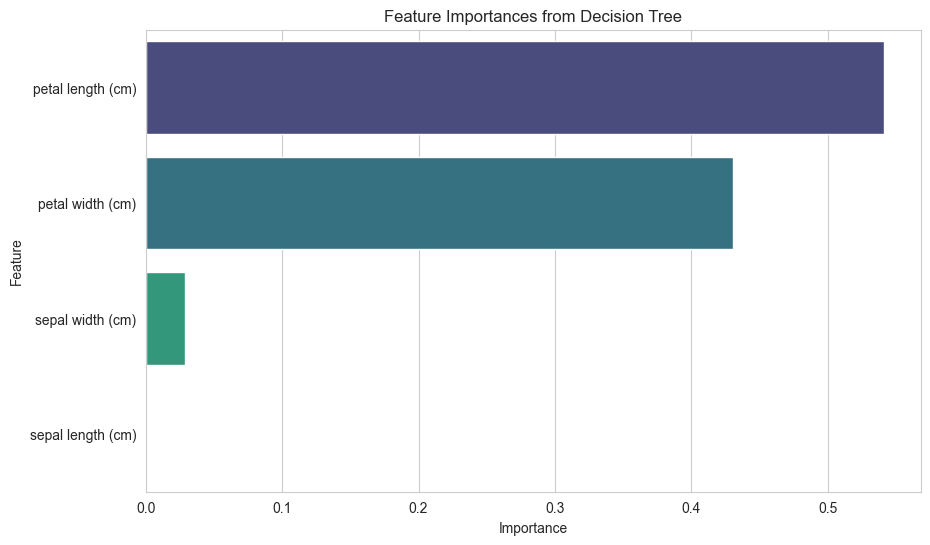

In [10]:
# Using the model trained on all features (dt_classifier)
importances = dt_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_df_all.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances from Decision Tree')
plt.show()

## Controlling Tree Complexity / Pruning
A fully grown tree can easily overfit. We can control its complexity using hyperparameters like `max_depth`.


Accuracy of pruned tree (max_depth=3): 0.9778 (Original accuracy: 0.9333)


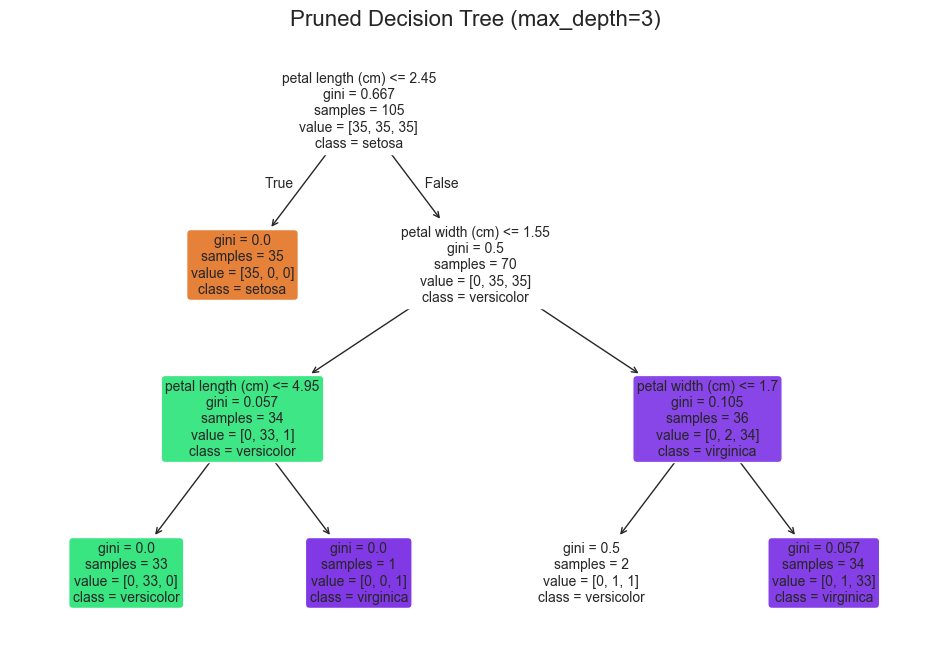

In [11]:
# Train a decision tree with limited depth
dt_classifier_pruned = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42) # Limiting depth to 3
dt_classifier_pruned.fit(X_train, y_train)

# Evaluate pruned tree
y_pred_pruned = dt_classifier_pruned.predict(X_test)
accuracy_pruned = metrics.accuracy_score(y_test, y_pred_pruned)
print(f"\nAccuracy of pruned tree (max_depth=3): {accuracy_pruned:.4f} (Original accuracy: {accuracy:.4f})")

# Visualize the pruned tree
plt.figure(figsize=(12,8))
plot_tree(dt_classifier_pruned,
          filled=True,
          rounded=True,
          class_names=target_names,
          feature_names=X_df_all.columns,
          fontsize=10)
plt.title("Pruned Decision Tree (max_depth=3)", fontsize=16)
plt.show()

Limiting `max_depth` results in a simpler, more generalizable tree, potentially at the cost of some training accuracy, but often improving test accuracy or reducing overfitting. Other parameters like `min_samples_split`, `min_samples_leaf`, and `ccp_alpha` (for cost-complexity pruning) can also be used.

## Decision Trees for Regression (Brief Example)

Decision trees can also predict continuous values. The splitting criterion is typically Mean Squared Error (MSE) reduction, and leaf nodes predict the average target value of samples in that leaf.


Decision Tree Regression (max_depth=3) Evaluation:
Mean Squared Error (MSE): 0.0505
R-squared (R²): 0.8898


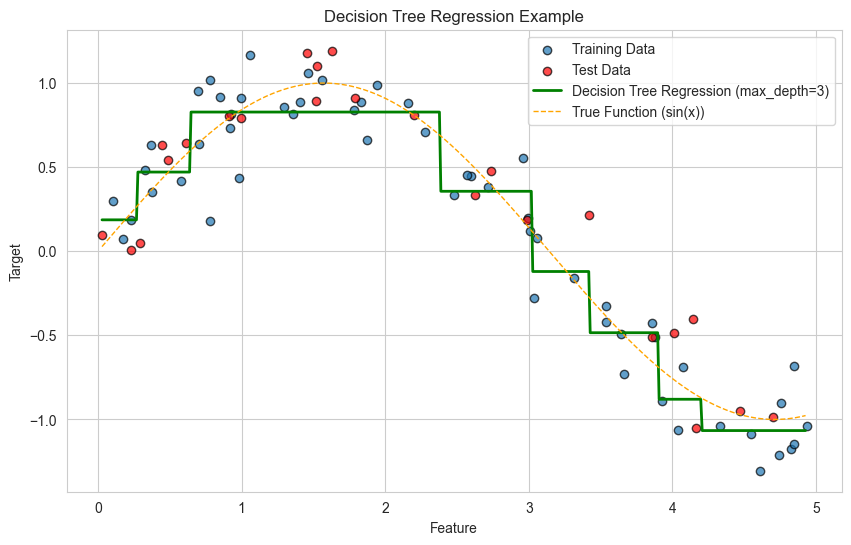

In [12]:
# Generate some simple 1D synthetic data for regression
np.random.seed(42)
X_reg = np.sort(5 * np.random.rand(80, 1), axis=0)
y_reg = np.sin(X_reg).ravel() + np.random.randn(80) * 0.2 # sin(x) + noise

# Split data
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42) # Try different max_depth values
dt_regressor.fit(X_reg_train, y_reg_train)

# Predictions
y_reg_pred = dt_regressor.predict(X_reg_test)

# Evaluation
mse_reg = metrics.mean_squared_error(y_reg_test, y_reg_pred)
r2_reg = metrics.r2_score(y_reg_test, y_reg_pred)
print(f"\nDecision Tree Regression (max_depth=3) Evaluation:")
print(f"Mean Squared Error (MSE): {mse_reg:.4f}")
print(f"R-squared (R²): {r2_reg:.4f}")

# Plotting the results
X_plot_reg = np.arange(X_reg.min(), X_reg.max(), 0.01)[:, np.newaxis]
y_plot_pred_reg = dt_regressor.predict(X_plot_reg)

plt.figure(figsize=(10, 6))
plt.scatter(X_reg_train, y_reg_train, alpha=0.7, edgecolor='k', label='Training Data')
plt.scatter(X_reg_test, y_reg_test, color='red', alpha=0.7, edgecolor='k', label='Test Data')
plt.plot(X_plot_reg, y_plot_pred_reg, color='green', linewidth=2, label=f'Decision Tree Regression (max_depth=3)')
plt.plot(X_plot_reg, np.sin(X_plot_reg), color='orange', linestyle='--', linewidth=1, label='True Function (sin(x))')
plt.title('Decision Tree Regression Example')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

The decision tree regressor creates a piecewise constant approximation. The depth of the tree controls how many "steps" are in the approximation.

## Conclusion & Key Takeaways

* Decision Trees are interpretable models that create a tree-like structure of decision rules for classification or regression.
* They work by recursively partitioning data based on feature thresholds that maximize purity (e.g., minimize Gini impurity or maximize Information Gain).
* **Key Strengths:** High interpretability (can be visualized), handles numerical/categorical data, no need for feature scaling.
* **Key Weaknesses:** Prone to overfitting (requires pruning/complexity control), can be unstable.
* Hyperparameters like `max_depth`, `min_samples_split`, and `min_samples_leaf` are crucial for controlling complexity and preventing overfitting.
* They form the basis for powerful ensemble methods like Random Forests and Gradient Boosting.

## Further Reading/References (Optional)

* [Scikit-learn Decision Trees Documentation](https://scikit-learn.org/stable/modules/tree.html)
* Chapter on Decision Trees in "An Introduction to Statistical Learning" by James, Witten, Hastie, and Tibshirani.
* StatQuest: Decision Trees, Clearly Explained.